## Reading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Read dataset.
- index_col='date' specifies the index column to be the date column
- parse_dates=True parses the index column as dates

In [3]:
with open('daily-total-female-births.csv', 'r') as f:
    df = pd.read_csv(f, index_col='Date', parse_dates=True)

In [4]:
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


Select the columns of interest:

In [5]:
birth_series = df['Births']

In [6]:
birth_series.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

Verify that it is a time series, i.e., the index is of the form DateTime:

In [7]:
type(birth_series.index)

pandas.core.indexes.datetimes.DatetimeIndex

Describe the series to look out for outliers (looking at min/max, mean, std...):

In [8]:
birth_series.describe()

count    365.000000
mean      41.980822
std        7.348257
min       23.000000
25%       37.000000
50%       42.000000
75%       46.000000
max       73.000000
Name: Births, dtype: float64

Visualizing the data:

## Visualizing data

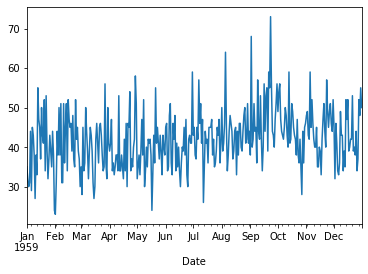

In [9]:
birth_series.plot()

This is a stationary series.

To look at the trends, it is much easier to smooth the series. You have to look for the moving average.
- df.rolling(window=20) computes the moving average with a window of 20 samples

In [10]:
birth_series_mean = birth_series.rolling(window=20).mean()

In [11]:
type(birth_series_mean)

pandas.core.series.Series

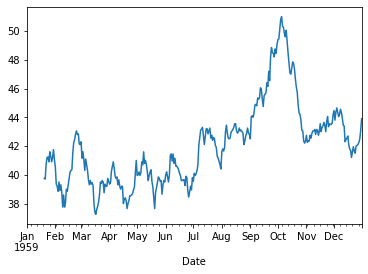

In [12]:
birth_series_mean.plot()

We clearly see a spike, so the time series is in fact **not stationary**. In stock market, there is a lot of noise and they use the moving average method to get smooth curves.

## Building a model

### Baseline model

**Assumption**: the previous value is the best reflection of the future (in the present day we will get the same result as yesterday)

Create a dataframe with one column being the real number of births and the other one being the predicted number of births with this naive model:

In [13]:
birth_df = pd.concat([birth_series, birth_series.shift(1)], axis=1)

In [14]:
birth_df.head()

,Births,Births
Date,,
1959-01-01,35,NaN
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0


Rename dataframe columns:

In [15]:
birth_df.columns =['Actual_birth', 'Forecast_birth']

In [16]:
birth_df.head()

,Actual_birth,Forecast_birth
Date,,
1959-01-01,35,NaN
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0


**Calculate error**:

First of all we need to remove NAN:

In [18]:
birth_df = birth_df[1:]

In [19]:
birth_df.head()

,Actual_birth,Forecast_birth
Date,,
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
1959-01-06,29,44.0
1959-01-07,45,29.0


In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [21]:
birth_squared_error = mean_squared_error(birth_df.Actual_birth, birth_df.Forecast_birth)

To be able to interpret this error we must take the square root:

In [51]:
NAIVE_error = np.sqrt(birth_squared_error)

In [52]:
NAIVE_error

9.188566377086019

## ARIMA model

ARIMA is the Autoregressive (p) Integrated (d) Moving Average model (q)
- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Parameters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

### Determine ARIMA parameters

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**plot_acf is to identify parameter q**

That is, we plot the autocorrelation of the time series, which is:  the correlation of the time series with the shifter time series. So the plot starts with shift 0, that is, the time series with itself (which will have a correlation 1). Then the plot shows the correlation of the time series with the same time series with a shift of 1, etc.

Since we want to obtain a stationary time series, we want to know what is the shift that gets rid of the correlation. The blue shadow indicates the critical correlation lower than which we can assume the two series are not correlated.

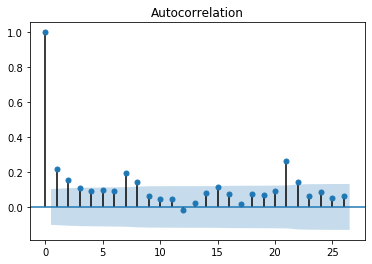

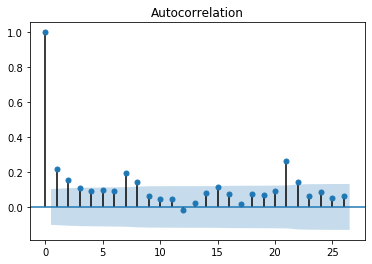

In [25]:
plot_acf(birth_series)

We would pick a value of q between 3-5

**plot_pacf is to identify p**

The partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

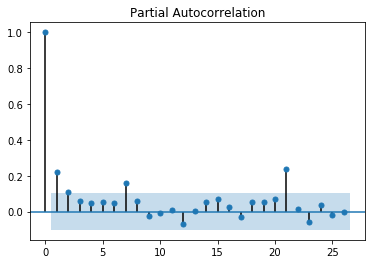

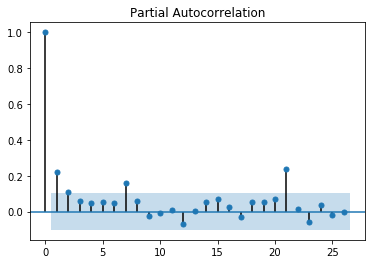

In [26]:
plot_pacf(birth_series)

We can take a value of p between 2-4

**plot the series is to identify d**

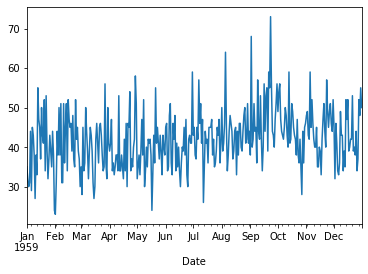

In [27]:
birth_series.plot()

Since the plot is stationary, d = 0

### Build ARIMA model

In [28]:
birth_series.size

365

Separate between train and test:

In [29]:
birth_train = birth_series[:330]
birth_test = birth_series[330:]

In [30]:
from statsmodels.tsa.arima_model import ARIMA

In [31]:
birth_model = ARIMA(birth_train, order=(2,0,3))

/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [32]:
birth_model_fit = birth_model.fit()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

Now we get an error that the time series was NOT stationary. We already identified that with the moving average. We can try differentiating 1, i.e., d=1:

In [33]:
birth_model = ARIMA(birth_train, order=(2,1,3))

/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [34]:
birth_model_fit = birth_model.fit()

In [35]:
birth_model_fit

### Evaluate model with AIC

The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.

When comparing two models, the one with the lower AIC is generally “better”.

In [36]:
birth_model_fit.aic

2230.948254271132

### Forecast

When forecasting, the steps parameter indicates the number of out of sample forecasts from the end of the sample.

The forecast method returns a triple:
- forecast ndarray: Array of out of sample forecasts

- stderr ndarray: Array of the standard error of the forecasts.

- conf_int ndarray: 2d array of the confidence interval for the forecast

In [45]:
birth_forecast = birth_model_fit.forecast(steps=35)[0]

In [47]:
birth_forecast

array([45.30368759, 46.3105886 , 43.64947622, 44.59220347, 46.49701503,
       44.34347849, 44.08985948, 46.34386502, 45.07533317, 43.88107493,
       45.95212042, 45.69574049, 43.97398968, 45.45672721, 46.10374039,
       44.31134452, 44.99233114, 46.26015703, 44.79344796, 44.66474084,
       46.18570356, 45.30635543, 44.53323021, 45.94668529, 45.74841678,
       44.60564598, 45.63338627, 46.04982532, 44.84524238, 45.33693761,
       46.18217491, 45.18585347, 45.12982951, 46.15764759, 45.55080382])

Compare with test:

In [49]:
ARIMA_error = np.sqrt(mean_squared_error(birth_test, birth_forecast))

In [50]:
ARIMA_error

6.859970017788597

In [53]:
NAIVE_error

9.188566377086019

We have minimized the error :-)

### Try other parameters

In [54]:
birth_train

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-11-22    40
1959-11-23    57
1959-11-24    49
1959-11-25    45
1959-11-26    49
Name: Births, Length: 330, dtype: int64

In [68]:
p_list = [2,3,4]
d_list = [0,1,2]
q_list = [3,4,5]
error = np.zeros((3,3,3)) 
for i, p in enumerate(p_list):
    for j, d in enumerate(d_list):
        for k, q in enumerate(q_list):
            birth_model = ARIMA(birth_train, (p,d,q))
            try:
                birth_model_fit = birth_model.fit()
                birth_forecast = birth_model_fit.forecast(steps=35)[0]
                error[i,j,k] = np.sqrt(mean_squared_error(birth_test, birth_forecast))
            except:
                error[i,j,k] = -1

/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.

/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/usuari/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.


In [69]:
error

array([[[-1.        , -1.        , -1.        ],
        [ 6.85997002,  6.82658923,  7.06056389],
        [-1.        , -1.        , -1.        ]],

       [[ 6.55681901, -1.        , -1.        ],
        [ 6.72526973,  6.61670417, -1.        ],
        [-1.        , -1.        , -1.        ]],

       [[ 6.52227515,  6.47668411, -1.        ],
        [ 7.1297073 ,  7.38960351,  7.33692423],
        [-1.        , -1.        , -1.        ]]])